In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
import re
from dateutil import parser


In [12]:
!pwd

/Users/michaelmerrill/chia


In [13]:
results_paths_dict = {
    'PHIA': [
        './data/auto_eval/final_v2_1000Questions_20240303_0306_nonagent_False_10shots_5max_steps_per_request_Falsefew_shots_type_knn_active_achiver.csv',
        './data/auto_eval/final_v2_1000Questions_20240302_0454_nonagent_False_10shots_5max_steps_per_request_Falsefew_shots_type_knn.csv',
        './data/auto_eval/final_v2_1000Questions_20240302_1734_nonagent_False_10shots_5max_steps_per_request_Falsefew_shots_type_knn_sedentary_sleeper.csv',
        './data/auto_eval/final_v2_1000Questions_20240302_2205_nonagent_False_10shots_5max_steps_per_request_Falsefew_shots_type_knn_inactive_insomniacs.csv',
    ],
    'Code Generation': [
        './data/auto_eval/final_v2_1000Questions_20240306_0312_nonagent_True_10shots_5max_steps_per_request_Truefew_shots_type_knn_health_behavior.csv',
        './data/auto_eval/final_v2_1000Questions_20240302_2127_nonagent_True_10shots_5max_steps_per_request_Truefew_shots_type_knn_sedentary_sleeper.csv',
        './data/auto_eval/final_v2_1000Questions_20240306_1125_nonagent_True_10shots_5max_steps_per_request_Truefew_shots_type_knn_inactive_insomniacs.csv',
        './data/auto_eval/final_v2_1000Questions_20240306_1533_nonagent_True_10shots_5max_steps_per_request_Truefew_shots_type_knn_active_achiver.csv',
    ]
}

numerical_reasoning_results_paths = {
    'health_behavior': [
        './data/auto_eval/health_behavior_10shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/health_behavior_5shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/health_behavior_final_v2.csv',
    ],
    'sedentary_sleeper': [
        './data/auto_eval/sedentary_sleeper_10shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/sedentary_sleeper_5shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/sedentary_sleeper_final_v2.csv',
    ],
    'inactive_insomniacs': [
        './data/auto_eval/inactive_insomniacs_10shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/inactive_insomniacs_5shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/inactive_insomniacs_final_v2.csv',
    ],
    'active_achiver': [
        './data/auto_eval/active_achiver_10shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/active_achiver_5shots_gemini_advanced_phia_2.csv',
        './data/auto_eval/active_achiver_final_v2.csv',
    ],
}


In [14]:
def is_datetime_like(answer: str) -> bool:
  """Check if the answer is datetime-like."""
  if isinstance(answer, str) and 'datetime' in answer:
    return True
  try:
    pd.to_datetime(answer)
    return True
  except ValueError as e:
    return False


def try_parse(value):
  """Try to parse a string."""
  try:
    float_val = float(value)
    int_val = int(float_val)
    return int_val if float_val == int_val else float_val
  except (ValueError, TypeError):
    pass
  # Try to parse as datetime
  try:
    return parser.parse(value)
  except (ValueError, TypeError):
    pass
  # Try to parse as list
  try:
    if value.startswith('[') and value.endswith(']'):
      # Use ast.literal_eval for safe evaluation of the string as a list
      list_val = ast.literal_eval(value)
      if isinstance(list_val, list):
        # Recursively apply parsing to each item in the list
        return [
            try_parse(item) if isinstance(item, str) else item
            for item in list_val
        ]
  except (ValueError, SyntaxError):
    pass
  # Return the original value if all conversions fail
  return value


def parse_series(series):
  """Parse a series."""
  return series.apply(lambda x: try_parse(x) if isinstance(x, str) else x)


def extract_final_answer(val):
  try:
    # Find the final_answer key and extract its value
    match = re.search(r"'final_answer':\s*'([^']*)'", val)
    if match:
      return match.group(1).strip()
    else:
      return None
  except Exception as e:
    print(f'Error extracting final_answer: {e}')
    return None


def extract_key_question(text):
  # Split the text by "[Question:" and take the last part if it exists
  parts = text.split('[Question]:')
  return parts[-1][1:-1]


def extract_label(question: str, df_gt: pd.DataFrame) -> str:
  """Extracts the label from the question."""
  filtered_df = df_gt[df_gt['question'].str.contains(question, na=False)]
  if not filtered_df.empty:
    return filtered_df['label'].iloc[0]
  else:
    return None  # Or some default value


def unify_zero(value):
  try:
    num = float(value)
    if num == 0:
      return '0'
    return value
  except ValueError:
    return value


# Function to round floats to two decimal places, and leave other strings unchanged
def round_floats(value):
  try:
    num = float(value)
    return f'{num:.2f}'
  except ValueError:
    return value


def generate_text_results(df_path: str, df_gt_path: str):
  """Generates the results."""
  df = pd.read_csv(df_path)
  df_gt = pd.read_csv(df_gt_path)
  df['key_question'] = df['question'].apply(extract_key_question)
  df['label'] = df['key_question'].apply(
      lambda question: extract_label(question, df_gt)
  )
  df['label'] = df['label'].astype(str)
  df['extracted_answer'] = df['extracted_answer'].astype(str)
  df['label'] = df['label'].apply(unify_zero)
  df['label'] = df['label'].apply(round_floats)
  df['extracted_answer'] = df['extracted_answer'].apply(unify_zero)
  df['extracted_answer'] = df['extracted_answer'].apply(round_floats)
  return df['extracted_answer'].to_list(), df['label'].to_list()


def find_first_number(s):
  # Check if the input is None and return None immediately if it is
  if s is None:
    return None
  # Use regular expression to find all sequences of digits possibly including a decimal point
  numbers = re.findall(r'\d+\.\d+|\d+', s)
  # Check if we found any numbers
  if numbers:
    # Check if the found number is a decimal or an integer
    if '.' in numbers[0]:
      # Convert the first found decimal number to a float and return it
      return round(float(numbers[0]), 2)
    else:
      # Convert the first found integer number to an integer and return it
      return int(numbers[0])
  else:
    # Return None if no numbers are found
    return None


def read_inference_results(result_path):
  to_evaluate_df = pd.read_csv(result_path)
  to_evaluate_df['label'] = parse_series(to_evaluate_df['label'])

  # Apply the function to the 'results' column
  to_evaluate_df['final_answer'] = to_evaluate_df['results'].map(
      extract_final_answer
  )

  to_evaluate_df['phia_code_html'] = (
      to_evaluate_df['results']
      .dropna()
      .map(lambda x: x.get('html') if isinstance(x, dict) else None)
  )
  to_evaluate_df['phia_answer'] = to_evaluate_df['final_answer'].map(
      find_first_number
  )
  to_evaluate_df['label'] = to_evaluate_df['label'].astype(str)
  to_evaluate_df['phia_answer'] = to_evaluate_df['phia_answer'].astype(str)
  to_evaluate_df['label'] = to_evaluate_df['label'].apply(unify_zero)
  to_evaluate_df['label'] = to_evaluate_df['label'].apply(round_floats)
  to_evaluate_df['phia_answer'] = to_evaluate_df['phia_answer'].apply(unify_zero)
  to_evaluate_df['phia_answer'] = to_evaluate_df['phia_answer'].apply(round_floats)
  return (
      to_evaluate_df['phia_answer'].to_list(),
      to_evaluate_df['label'].to_list(),
  )


In [15]:
phia_ground_truth = []
phia_predictions = []
code_generation_ground_truth = []
code_generation_predictions = []
numerical_reasoning_ground_truth = []
numerical_reasoning_predictions = []

for path in results_paths_dict['PHIA']:
  preds, gts = read_inference_results(path)
  phia_ground_truth.extend(gts)
  phia_predictions.extend(preds)

for path in results_paths_dict['Code Generation']:
  preds, gts = read_inference_results(path)
  code_generation_ground_truth.extend(gts)
  code_generation_predictions.extend(preds)

for persona_name in numerical_reasoning_results_paths.keys():
  gt_path = numerical_reasoning_results_paths[persona_name][2]
  df_10_shots = numerical_reasoning_results_paths[persona_name][0]
  preds, gts = generate_text_results(df_10_shots, gt_path)
  numerical_reasoning_ground_truth.extend(gts)
  numerical_reasoning_predictions.extend(preds)

final_results_df = pd.DataFrame({
    'Ground Truth': (
        phia_ground_truth
        + code_generation_ground_truth
        + numerical_reasoning_ground_truth
    ),
    'Predictions': (
        phia_predictions
        + code_generation_predictions
        + numerical_reasoning_predictions
    ),
    'Model': (
        ['PHIA'] * len(phia_ground_truth)
        + ['Code Generation'] * len(code_generation_ground_truth)
        + ['Numerical Reasoning'] * len(numerical_reasoning_ground_truth)
    ),
})


In [16]:
df = final_results_df

# Define bootstrapped exact match accuracy function
def bootstrapped_exact_match_accuracy(df, n_bootstraps=1000):
    n = int(len(df) / 10)
    bootstrapped_accuracies = []

    for _ in range(n_bootstraps):
        # Bootstrap sample
        sample_df = df.sample(n, replace=True)
        # Calculate exact match accuracy
        accuracy = (sample_df['Ground Truth'] == sample_df['Predictions']).mean()
        accuracy = accuracy * 100
        bootstrapped_accuracies.append(accuracy)
    return bootstrapped_accuracies

# Calculate bootstrapped accuracies for each model
all_bootstrapped_accuracies = []
all_models = []

for model in df['Model'].unique():
    model_df = df[df['Model'] == model]
    bootstrapped_accuracies = bootstrapped_exact_match_accuracy(model_df)
    all_bootstrapped_accuracies.extend(bootstrapped_accuracies)
    all_models.extend([model] * len(bootstrapped_accuracies))

results_df = pd.DataFrame({'Model': all_models, 'Mean Accuracy': all_bootstrapped_accuracies})


## Plotting

/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_61971/2021131192.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean Accuracy', y='Model', data=results_df,
/var/folders/wj/1srvs8v51rbbh49050rdwprw0000gn/T/ipykernel_61971/2021131192.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Numerical\nReasoning', 'Code\nGeneration', 'PHIA'])


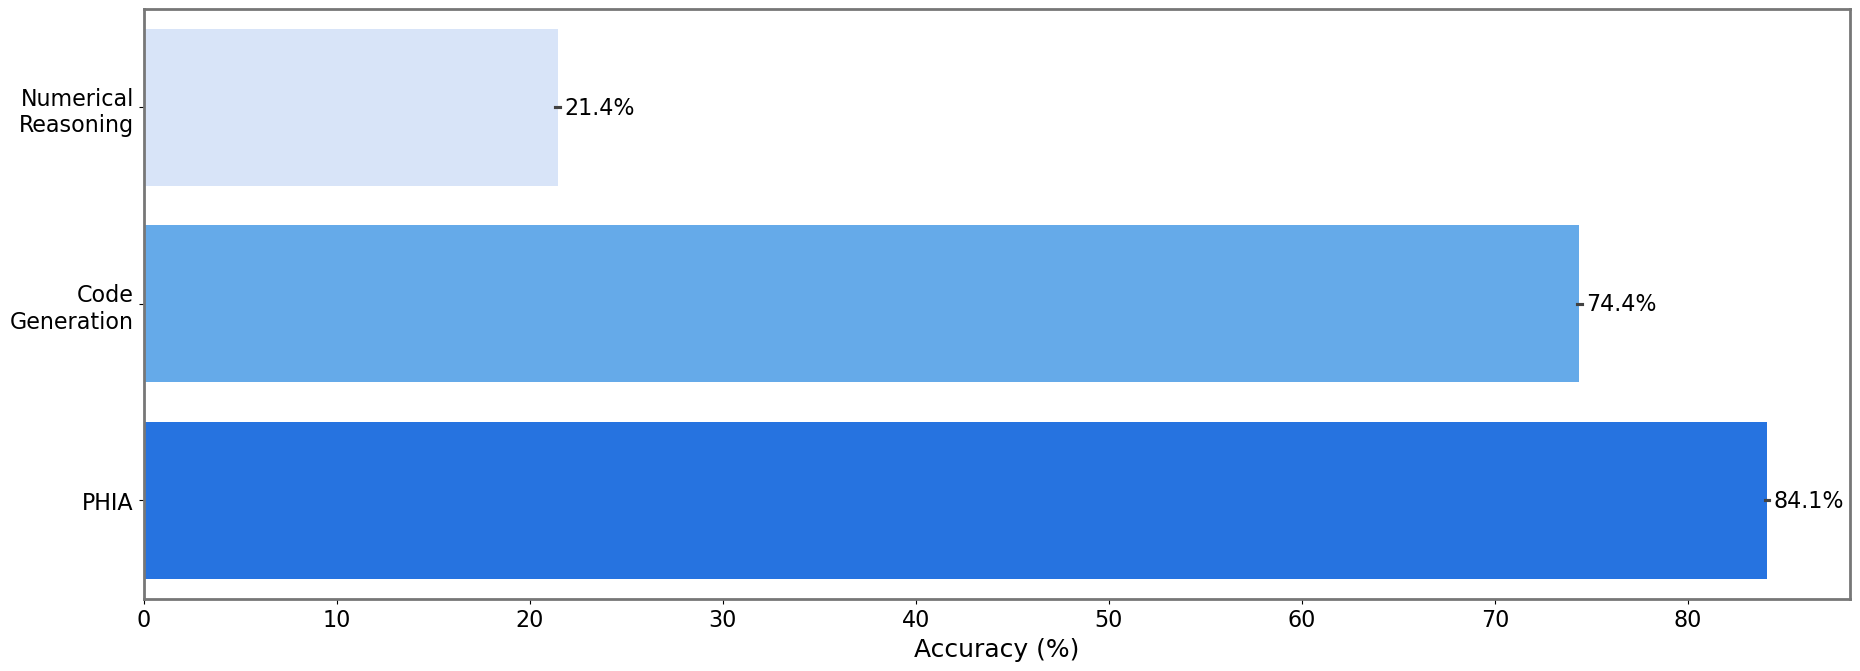

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the rcParams for plot aesthetics
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = "#777777"
plt.rcParams['axes.facecolor'] = '#FFFFFF'

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Define the new color palette
custom_palette = ['#D3E3FD', '#4FABFF', '#076EFF']

# Plot using seaborn
plt.figure(figsize=(20, 7))  # Adjusting figure size for better readability
sns.barplot(x='Mean Accuracy', y='Model', data=results_df,
            errorbar=('ci', 95), palette=custom_palette, order=['Numerical Reasoning', 'Code Generation', 'PHIA'])

plt.xlabel('Accuracy (%)')
plt.ylabel(None)
plt.tight_layout()
ax = plt.gca()
ax.set_yticklabels(['Numerical\nReasoning', 'Code\nGeneration', 'PHIA'])

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%',
                (width, p.get_y() + p.get_height() / 2),
                ha='center', va='center',
                xytext=(30, 0),
                textcoords='offset points')

plt.savefig("figs/3a.pdf", bbox_inches='tight', format="pdf")
plt.show()
